In [1]:
import torch 

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
import glob 
import re
csv_files = glob.glob('C:/Users/pablo/Desktop/scripts tfg/archivos min/*.min')

# Create an empty dataframe to store the combined data
combined_df_min = pd.DataFrame()
ind=['min HFB','min PNP','min PNPAMP']
combined_df_min.index=ind
difE=[]
list_zn=[]
# Loop through each CSV file and append its contents to the combined dataframe
for csv_file in csv_files:
    df = pd.read_csv(csv_file,sep=' ',header=None)
    df.columns=['beta_2','E HFB','E PNP', 'E PNPAMP']
    zn=[int(s) for s in re.findall(r'\d+', csv_file)] 
    list_zn.append(zn)
    E_hfb=df.iloc[0,1]
    E_pnpamp=df.iloc[2,3]
    difE.append(E_pnpamp-E_hfb)



In [3]:
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyModel, self).__init__()
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(input_dim, 1000)
        self.fc2 = nn.Linear(1000, 750) 
        self.fc3 = nn.Linear(750,600)
        self.fc4 = nn.Linear (600, 800)
        self.fc5 = nn.Linear(800, output_dim)
        self.internal = nn.ReLU()
        self.activation = nn.ReLU()
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)        
        self.batchnorm1=nn.BatchNorm1d(1000, eps=1e-05, momentum=None)#batch norm should be frozen when evaluating the model
        self.batchnorm2=nn.BatchNorm1d(750, eps=1e-05, momentum=None)
        self.batchnorm3=nn.BatchNorm1d(600, eps=1e-05, momentum=None)
        self.batchnorm4=nn.BatchNorm1d(800, eps=1e-05, momentum=None)

    def forward(self, x):
        x1 = self.internal(self.fc1(x))
        x1= self.batchnorm1(x1)
        x1= self.dropout(x1)
        x2 = self.internal(self.fc2(x1))
        x2=self.batchnorm2(x2)
        x2= self.dropout(x2)
        x3 = self.internal(self.fc3(x2))
        x3=self.batchnorm3(x3)
        x3= self.dropout(x3)
        x4 = self.internal(self.fc4(x3))
        x4=self.batchnorm4(x4)
        x4= self.dropout(x4)
        y=self.activation(self.fc5(x4))
        return y 


In [4]:
x=torch.tensor(list_zn)
y=torch.tensor(np.abs(difE))

#x_train=torch.tensor(zn_train)


In [5]:
from torch.utils.data import TensorDataset, DataLoader

def create_dataloaders(x, y, split_ratio, batch):
    dataset = TensorDataset(x, y)

    train_size = int(len(dataset) * split_ratio/batch)
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    batch_size=int(train_size/batch)
    train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset,batch_size=test_size, shuffle=False)

    return train_loader, test_loader

In [7]:
def training_model(data_size, learning_rate, batch_size): 
    train_loader, test_loader = create_dataloaders(x,y,split_ratio=data_size, batch=batch_size)
    net_slice=MyModel(2,1)
    net_slice=net_slice.float()
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(net_slice.parameters(), lr=learning_rate)
    #start_time=time.time()        
    dloss=1
    loss_item=[]
    loss_item.append(0.0)
    i=0 
    nepoch=0
    net_slice.train()
    while dloss > 1e-2 :
        for batch_idx, (x_train_slice, y_train_slice) in enumerate(train_loader):
            x_train_slice = x_train_slice.float()
            y_train_slice = y_train_slice.float()
            hatY_slice = net_slice.forward(x_train_slice)
            optimizer.zero_grad()
            loss_slice = criterion(hatY_slice, y_train_slice)
            loss_slice.backward()
            optimizer.step()
            # solo sobre el test    
            #acc=np.std()#loss segun tamaño entreno y test y varianza
            #entrenar sobre las propias energías
            #hablar sobre tiempos de computación
            #rel_acc=acc/y_test.mean()
            if nepoch % 100 == 0 and batch_idx==batch_size-1:
                loss_item.append(loss_slice.item())
                dloss=np.abs(loss_item[i+1]-loss_item[i])
                i+=1
        nepoch+=1
            
    #elapsed_time = time.time() - start_time
    net_slice.eval()
    for x_test_slice, y_test_slice in test_loader:
        x_test_slice=x_test_slice.float()
        y_test_slice=y_test_slice.float()
        hatY_pred_slice=net_slice.forward(x_test_slice)
        hatY_detach_slice=hatY_pred_slice.detach()
        total_loss_slice=criterion(hatY_detach_slice,y_test_slice)
    return total_loss_slice, dloss, loss_slice, nepoch, hatY_slice, hatY_pred_slice, x_train_slice, x_test_slice, y_train_slice, y_test_slice


In [8]:
#grid search
learning_rates=np.logspace(-5,-1,5)
data_sizes=np.array([0.3,0.4,0.5,0.6,0.7,0.8])
test_loss=np.zeros((len(data_sizes), len(learning_rates)))
train_loss= np.zeros_like(test_loss)
nepochs=np.zeros_like(test_loss)
fontsize=16
for a_iter, data_size in enumerate(data_sizes):
    for b_iter, learning_rate in enumerate(learning_rates):
        total_loss_slice, dloss, loss_slice, i, hatY_slice, hatY_pred_slice,  x_train_slice, x_test_slice, y_train_slice, y_test_slice=training_model(data_size=data_size, learning_rate=learning_rate, batch_size=4)
        test_loss[a_iter,b_iter]=total_loss_slice.item()
        train_loss[a_iter, b_iter]=loss_slice.item()
        nepochs[a_iter,b_iter]=i



c:\Users\pablo\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\pablo\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1584])) that is different to the input size (torch.Size([1584, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\pablo\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to inco

In [9]:
import matplotlib.pyplot as plt

def plot_data(x,y,data, title):

    # plot results
    fontsize=12


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=2, cmap="cool")
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('loss',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.4,.8,1.2,1.6,2])
    cbar.set_ticklabels(['0','0.4','0.8','1.2','1.6','2'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            if data[j,i]>1000:
                c = "{0:.1e}".format( data[j,i]) 
            else:
                c = "{0:.2f}".format( data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y*100]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels([""]+y)

    ax.set_xlabel('Tasa de aprendizaje',fontsize=fontsize)
    ax.set_ylabel("Tamaño de datos de entrenamiento (%)",fontsize=fontsize)
    ax.set_title(title)

    plt.tight_layout()

    plt.show()
    

C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


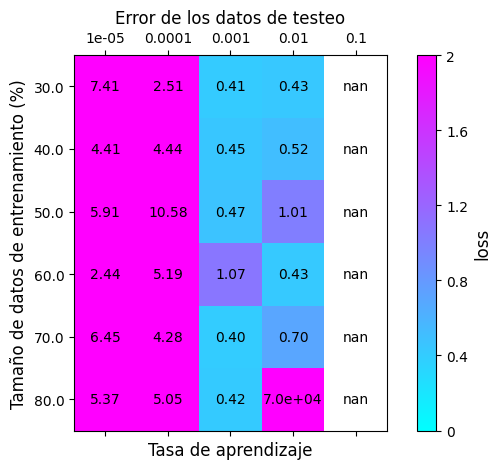

In [10]:
plot_data(learning_rates, data_sizes, test_loss, "Error de los datos de testeo")

C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


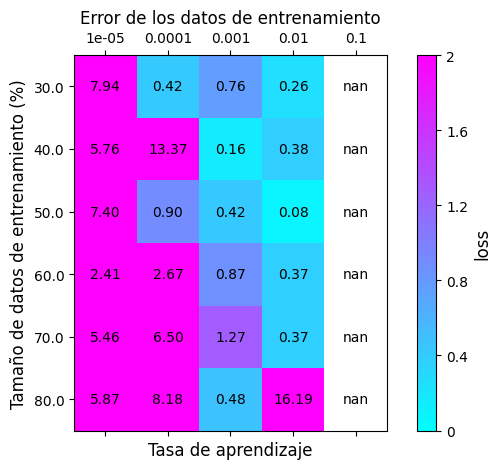

In [11]:
plot_data(learning_rates, data_sizes, train_loss, "Error de los datos de entrenamiento")

In [12]:
import matplotlib.pyplot as plt

def plot_data_epochs(x,y,data, title: str):

    # plot results
    fontsize=12


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=4000, cmap="cool")
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('número iteraciones',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,800,1600,2400,3200,4000])
    cbar.set_ticklabels(['0','800','1600','2400','3200','4000'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "{0:.01f}".format( data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y*100]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels([""]+y)

    ax.set_xlabel('Tasa de aprendizaje',fontsize=fontsize)
    ax.set_ylabel("Tamaño de datos de entrenamiento (%)",fontsize=fontsize)
    ax.set_title(title)

    plt.tight_layout()

    plt.show()
    

C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


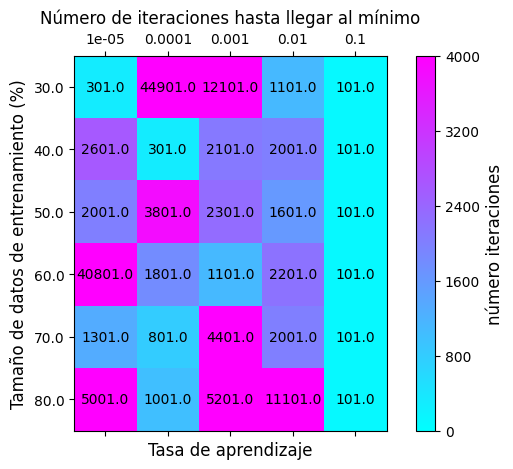

In [13]:
plot_data_epochs(learning_rates, data_sizes, nepochs, "Número de iteraciones hasta llegar al mínimo")

In [14]:
import pandas as pd

# Create a DataFrame from the NumPy array
df = pd.DataFrame(test_loss, 
                  columns=['1e-05', '0.0001', '0.001', '0.01', '0.1'],  # Example learning rates
                  index=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8])  # Example data sizes

# Save to CSV
df.to_csv('test_loss.csv')
df = pd.DataFrame(train_loss, 
                  columns=['1e-05', '0.0001', '0.001', '0.01', '0.1'],  # Example learning rates
                  index=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8])  # Example data sizes

# Save to CSV
df.to_csv('train_loss.csv')
df = pd.DataFrame(nepochs, 
                  columns=['1e-05', '0.0001', '0.001', '0.01', '0.1'],  # Example learning rates
                  index=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8])  # Example data sizes

# Save to CSV
df.to_csv('nepochs.csv')


In [81]:
total_loss_slice, dloss, loss_slice, nepoch, hatY_slice, hatY_pred_slice, x_train_slice, x_test_slice,  y_train_slice, y_test_slice = training_model(0.3, 1e-2)

In [93]:
from calendar import c


def marker_plot(x_train,y_train,data_train,x_test,y_test,data_test):
    plt.figure(figsize=(12,6))
    # First subplot for the even indexed data
    plt.subplot(121)
    sc = plt.scatter(x_train[:, 1], x_train[:, 0], c=np.abs(data_train[:, 0]-y_train))
    plt.xlabel('N')
    plt.ylabel('Z')
    plt.title('Entrenamiento')
    plt.colorbar(sc, label="Diferencia")

    # Second subplot for the odd indexed data
    plt.subplot(122)
    sc = plt.scatter(x_test[:, 1], x_test[:, 0], c=np.abs(data_test[:, 0]-y_test))
    plt.xlabel('N')
    plt.ylabel('Z')
    plt.title('Testeo')
    plt.colorbar(sc, label="Diferencia")
    plt.show()

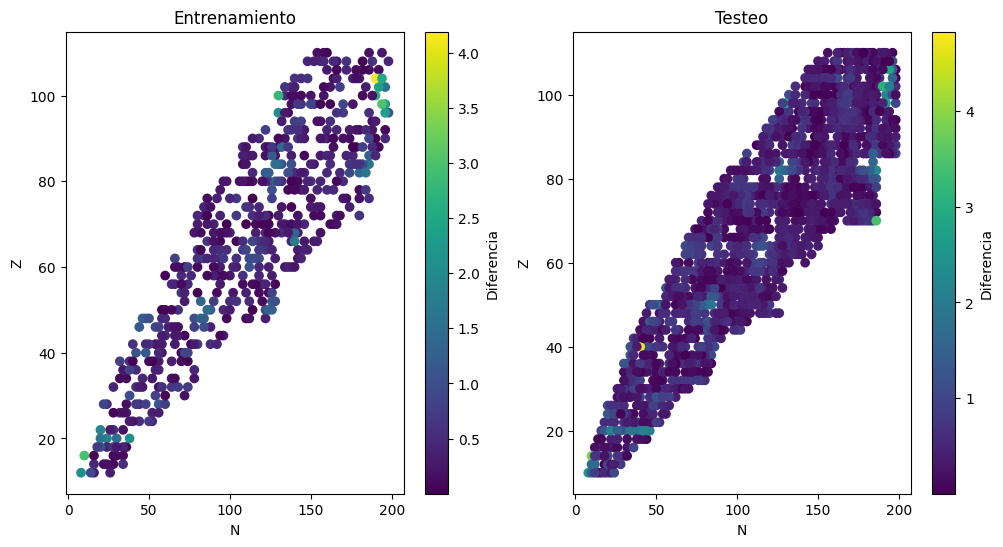

In [94]:
marker_plot(x_train_slice,y_train_slice, hatY_slice.detach(),x_test_slice,y_test_slice, hatY_pred_slice.detach())

In [95]:
np.savetxt('data_train_Adam_30_and_1e-2.csv', torch.column_stack((x_train_slice, y_train_slice)).numpy(), delimiter=',', header='Z,N,Y', comments='')
np.savetxt('data_test_Adam_30_and_1e-2.csv', torch.column_stack((x_test_slice, y_test_slice)).numpy(), delimiter=',', header='Z,N,Y', comments='')

In [18]:
df=pd.read_csv('data_E.csv')

In [28]:
df['difE'].values

array([-1.08349711, -2.28034484, -2.79498443, ..., -4.02121971,
       -4.07304257, -3.77964148])

In [21]:
df.columns

Index(['# Z', 'N', 'difE', 'E_HFB', 'E_PNP', 'E_PNPAMP'], dtype='object')